# Set 3

# TASK C OF PROBLEM 17 AT THE END OF THE DOCUMENT WITH THE DIAGRAMS AND CALCULATIONS OF PROBLEM 18

## Problem 17

### Task a

k-means is an unsupervised learning algorithm used to study the structure of a dataset. It takes $n$ observations of $p$ features and partitions them into $k$ non-overlapping clusters (this means that no observations fall into more than one cluster). Here the inputs are the $n$ observations and the amount of clusters to find $k$, while the output are the clusters as found by the algorithm. This gives a measure of how close observations are between each other, which can tell us a lot about the structure of the data we are studying; we can see what features are the main differentiators between the different classes, from which we can start to understand how we can correlate the observed phenomena with our measurements.

Some things that we must keep in mind are:

1. The parameter $k$ is defined by us, and the algorithm just tries to find those $k$ subgroups. The choice of $k$ can be very influential in our final results, and we can understand this by looking at extreme cases. if $k=1$, then we will end up having a single class for the whole dataset, which is not informative about the data since we're just left with our initial dataset. On the other hand, if $k=n$, the algorithm will then throw each observation into its own, single class, which is also not very informative. We wish to find a $k$ that maximizes the information we can get out of the dataset.
2. The algorithm starts with random initialization and finds a local optimum. This means that sometimes we may get a bad clustering, so we should be wary about this and try to run the algorithm a couple of times to make sure we have a good clustering. This is addressed a bit more in problem 19.

### Task b
The algorithm seeks to partition the data into $K$ subgroups in a way that minimizes the total within-cluster variation across all $K$ clusters, and the variation itself is measured by some distance metric such as Euclidean distance. First we define the clusters such that:

$$C_1 \cup C_2 \cup \cdots \cup C_K = {\text{dataset}}$$

$$k \neq k' \Rightarrow C_k \cap C_k' = \emptyset$$

From these, when we use the Euclidean distance, the function to minimize is given by:

$$ \min_{C_1, \dots, C_K} \left\{\sum_{k=1}^{K} \frac{1}{\left|C_k\right|} \sum_{i, i' \in C_k} \sum_{j=1}^{p} \left(x_{ij} - x_{i'j}\right)^2\right\}$$

Where $|C_k|$ is the number of observations within the $k$-th cluster. The algorithms guarantees lowering the value of this function at each iteration (unless we have already found optimal centroids), but it is subject to initial conditions as it finds a local minimum. This means that we should run the algorithm a couple of times with different initializations to ensure that we find something with a relatively low within-cluster variation.

# TASK C OF PROBLEM 17 AT THE END OF THE DOCUMENT WITH THE DIAGRAMS AND CALCULATIONS OF PROBLEM 18

## Problem 18, task b discussion

Complete linkage will yield more balanced results for better interpretation. The single linkage will produce skewed dendrograms, with an small cost function for merging the clusters. That is why they appear so flatten and close to each other. 
On the other hand, Complete linkage has higher complexity both in time and memory. It needs to update its distance matrix in each step, calculating the new distances. In the case of single linkage, this also has to happen, but it is not necessary. The matrix does not change because it doesn't matter if you take i or j, both will still have the same distance to the other points, therefore, it is not necessary to update the distance matrix, just know which distance are elegible and which one aren't.

The structure with max link dissimilarity is a bit clearer than with single link dissimilarity. The single link
merges clusters together one by one, whereas the clusters by max link are more evenly sized. Admittedly,
this effect is not the most clear in this example.

Complete linkage produces a more interpretable dendrogram since it balances out the clusters better; with single link the dendrograms tend to end up more skewed because of the cost function used. The complete linkage produces a dendrogram that is more evenly sized

## Problem 19

### Task a

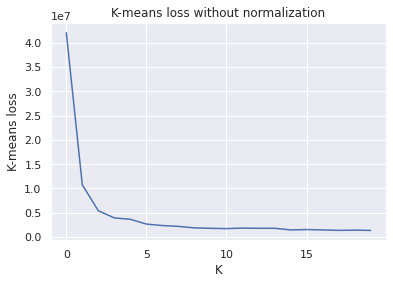

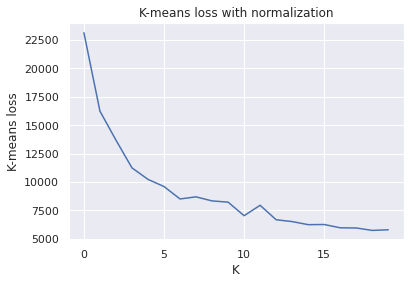

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
sns.set()

npf = pd.read_csv("../assets/npf_train.csv", index_col="id")

def formatDF(df, normalize=True, categorical_to_numeric = True):
    df = df[df.columns.drop(list(df.filter(regex='.std')))]
    df = df.drop(["date", "partlybad"], axis=1)
    
    if normalize:
        numerics = df.drop("class4", axis=1)
        numerics = (numerics - numerics.mean()) / numerics.std()
        df.loc[:, df.columns != 'class4'] = numerics
    
    if categorical_to_numeric:
        df["class4"] = df["class4"].astype("category").cat.codes
    
    return df

npf_unnormalized = formatDF(npf, normalize=False).drop("class4", axis=1)
npf_normalized = formatDF(npf, normalize=True).drop("class4", axis=1)
npf.drop(["date", "partlybad"], axis=1)

losses_unnormalized = np.zeros(20)
losses_normalized = np.zeros(20)
for i in range(1, 21):
    losses_unnormalized[i-1] = KMeans(n_clusters = i, n_init = 1, init="random").fit(npf_unnormalized).inertia_
    losses_normalized[i-1] = KMeans(n_clusters = i, n_init = 1, init="random").fit(npf_normalized).inertia_

plt.plot(losses_unnormalized, label="k-means unnormalized")
plt.locator_params(axis="both", integer=True, tight=True)
plt.ylabel("K-means loss")
plt.xlabel("K")
plt.title("K-means loss without normalization")
plt.show()

plt.plot(losses_normalized, label="k-means normalized")
plt.locator_params(axis="both", integer=True, tight=True)
plt.ylabel("K-means loss")
plt.xlabel("K")
plt.title("K-means loss with normalization")

# plt.legend()

plt.show()

We can see that normalizing the data greatly reduces the K-means loss, by around two orders of magnitude. This is because we use distance metrics to calculate the centroids, and the different features have very different scales. By normalizing the data, we bring them to "around the same level of importance"; without normalization, we're skewing our calculated distances toward the variables with higher magnitudes, even if features on smaller scales can bring us a similar level of information (for example, CO2 levels are in the hundreds, while UV radiation is measured in a scale of $10^{-2}$). In general we should normalize our data.

### Task b

In [23]:
cl = KMeans(n_clusters = 4, n_init = 1, init="random").fit(npf_normalized.to_numpy())

tt = pd.DataFrame({"class": npf.class4, "cluster": cl.labels_})
tt = tt.groupby(["class", "cluster"]).size().unstack().fillna(0)

lsa = linear_sum_assignment(tt, maximize = True)
pairs = {tt.index[i]: tt.columns[j] for i, j in zip(*lsa)}

tt.columns = ['Ia','nonevent','Ib','II']
tt = tt.reindex(sorted(tt.columns), axis=1)

print("Cluster labels: ", pairs)
tt

Cluster labels:  {'II': 3, 'Ia': 0, 'Ib': 2, 'nonevent': 1}


,II,Ia,Ib,nonevent
class,,,,
II,36.0,1.0,55.0,21.0
Ia,3.0,0.0,22.0,9.0
Ib,11.0,0.0,65.0,9.0
nonevent,97.0,22.0,5.0,108.0


Each row of the dataframe presents the "classification" of each type of observation from the original data. For example, the first row shows how many datapoints of class `II` were classified as `II`, `Ia`, `Ib` or `nonevent`. From this we can gather that the correct classifications are on the diagonal of the matrix and all the other values correspond to misclassifications.

Since the initialization of the algorithm is random, the table's values vary between runs. With the current run, we can observe that there are a considerable amount of misclassifications of the `nonevent` class into `II`, and none of the `Ia` observations were classified as `Ia`. There are also many misclassifications of class `II` as `Ib`. All of this may be due to the distribution of the data: `nonevent` represents the most represented class. The dataset is divided roughly into 50% observations as nonevents and 50% as events, but the latter means that each specific event will have less representation. This makes it so that the underrepresented classes (in this case mainly `Ia`) get big errors, and clusters will be composed of mostly `nonevent` observations. We can verify the distribution of the data:

In [19]:
npf["class4"].value_counts(normalize=True)*100

nonevent    50.000000
II          24.353448
Ib          18.318966
Ia           7.327586
Name: class4, dtype: float64

### Task c

Minimum: 11239.905938655085
Maximum: 13451.35108793606


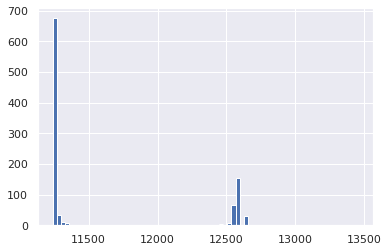

In [3]:
losses_log = np.zeros(1000)

for i in range(1000):
    losses_log[i] = KMeans(n_clusters = 4, n_init = 1, init="random").fit(npf_normalized).inertia_

plt.hist(losses_log, bins=75)

print("Minimum:", np.min(losses_log))
print("Maximum:", np.max(losses_log))

In [4]:
best_loss = np.min(losses_log)

# Get the frequency of getting a good loss on clustering: the amount of losses within 1% of the best loss divided by the total amount of losses
good_loss_freq = np.sum(losses_log <= 1.01*best_loss)/1000

good_loss_freq

0.728

We can treat this as a binomial distribution, where we have a probability of $p=\texttt{good_loss_freq}$ to get a good loss and $q=1-p$ to get a bad loss. The probability to get bad losses in k runs is q^k and the probability to have at least  one good loss would be given by $\texttt{good_loss_in_k} = 1-q^k$. For a 95% probability of having one good loss we solve for $k$ in:

$$1 - q^k \geq 0.95$$

In [5]:
q = 1 - good_loss_freq

1 - q**3

0.979876352

So after initializing four times randomly we should expect to have at least one good loss 95% of the time

Minimum: 11239.905938655085
Maximum: 13433.947952621742


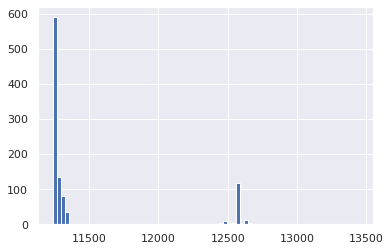

In [6]:
losses_log = np.zeros(1000)

for i in range(1000):
    losses_log[i] = KMeans(n_clusters = 4, n_init = 1).fit(npf_normalized).inertia_

plt.hist(losses_log, bins=75)

print("Minimum:", np.min(losses_log))
print("Maximum:", np.max(losses_log))

### Task d

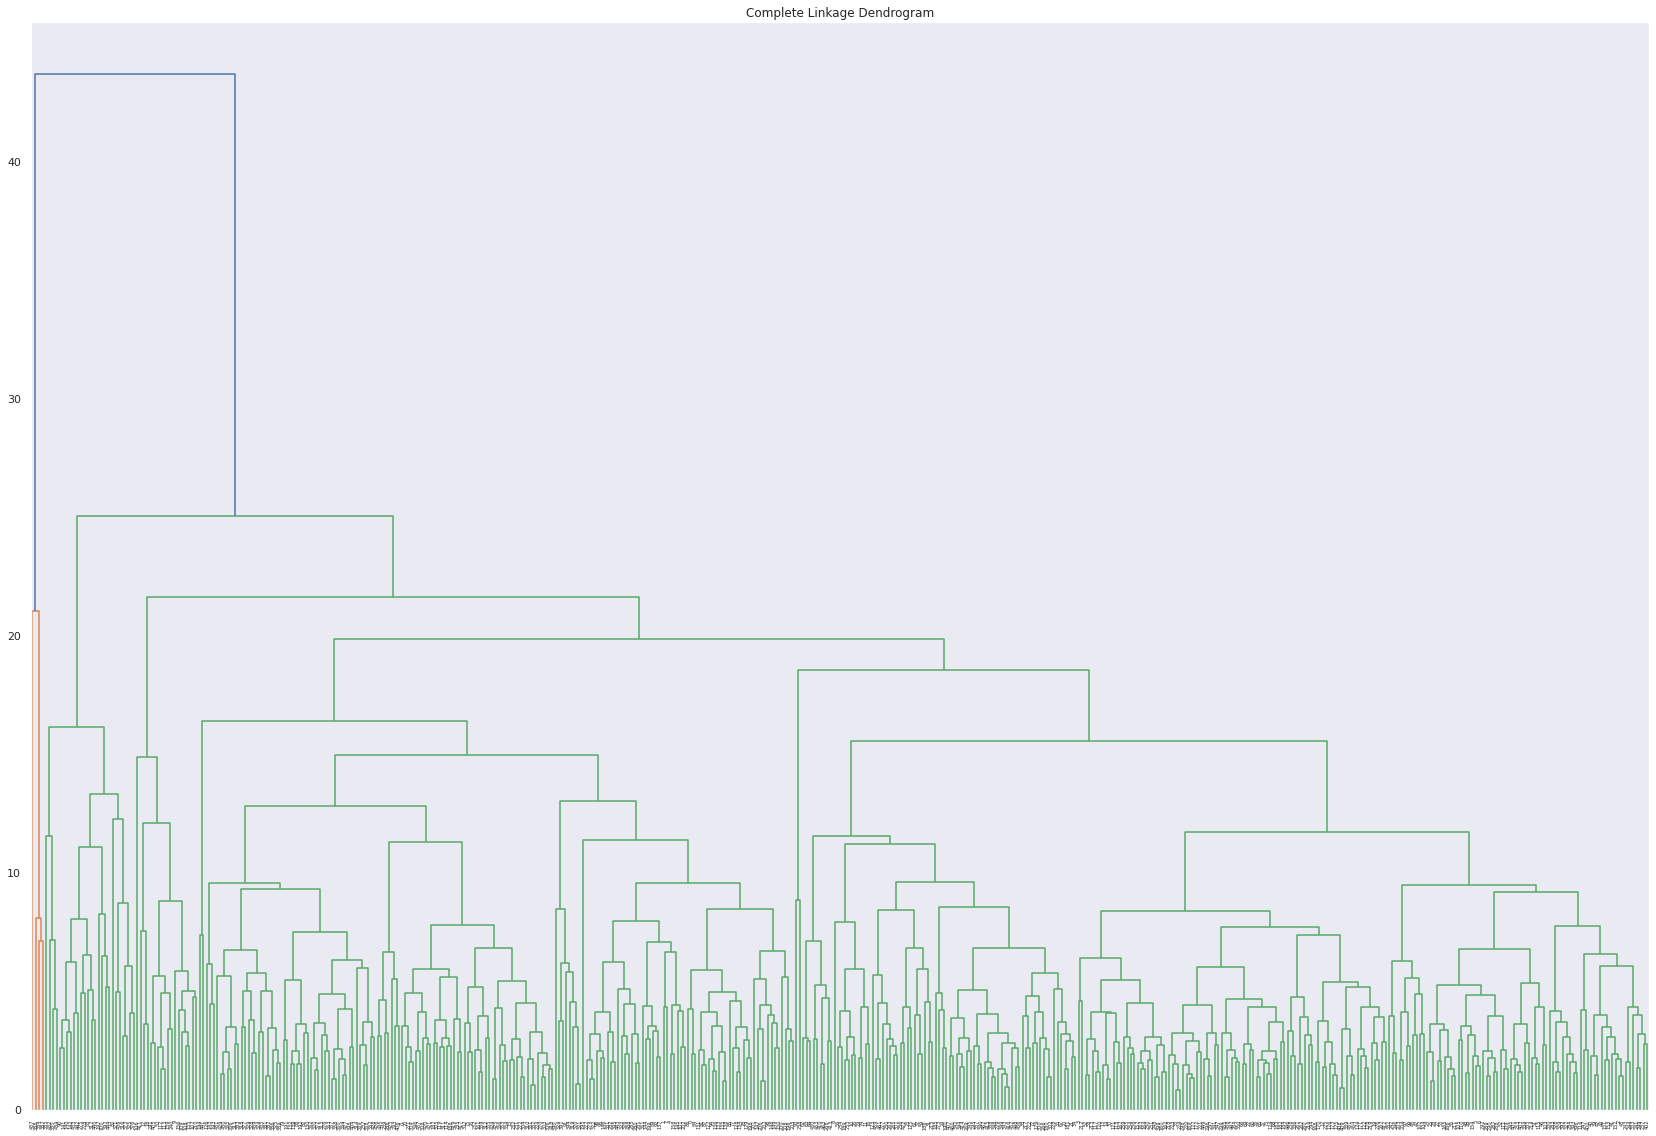

In [7]:
'''Based off of the dendrogram examples from sklearn available in https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html'''

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    return

complete = AgglomerativeClustering(linkage='complete',compute_distances=True)
complete = complete.fit(npf_normalized)

plt.figure(figsize=(29, 20))
plt.grid(visible=None)
plt.title("Complete Linkage Dendrogram")
plot_dendrogram(complete)

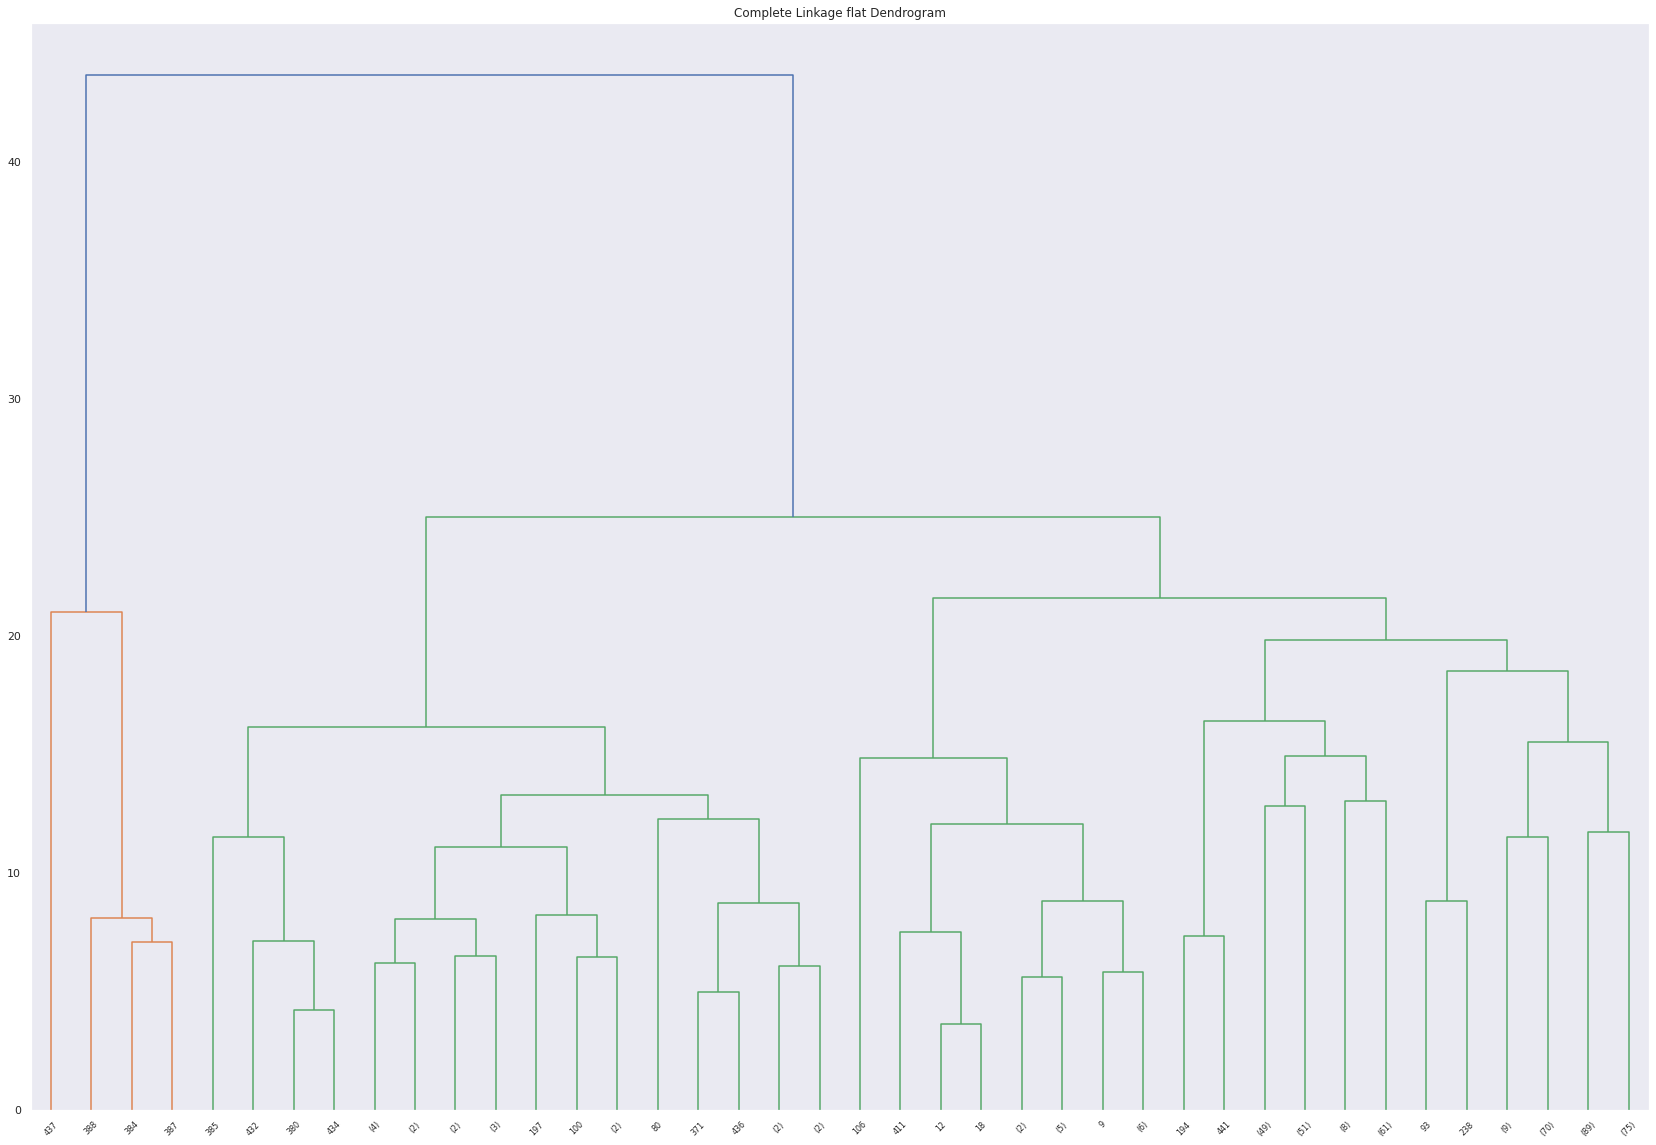

In [8]:
plt.figure(figsize=(29, 20))
plt.grid(visible=None)
plt.title("Complete Linkage flat Dendrogram")
plot_dendrogram(complete, truncate_mode="level", p=6)

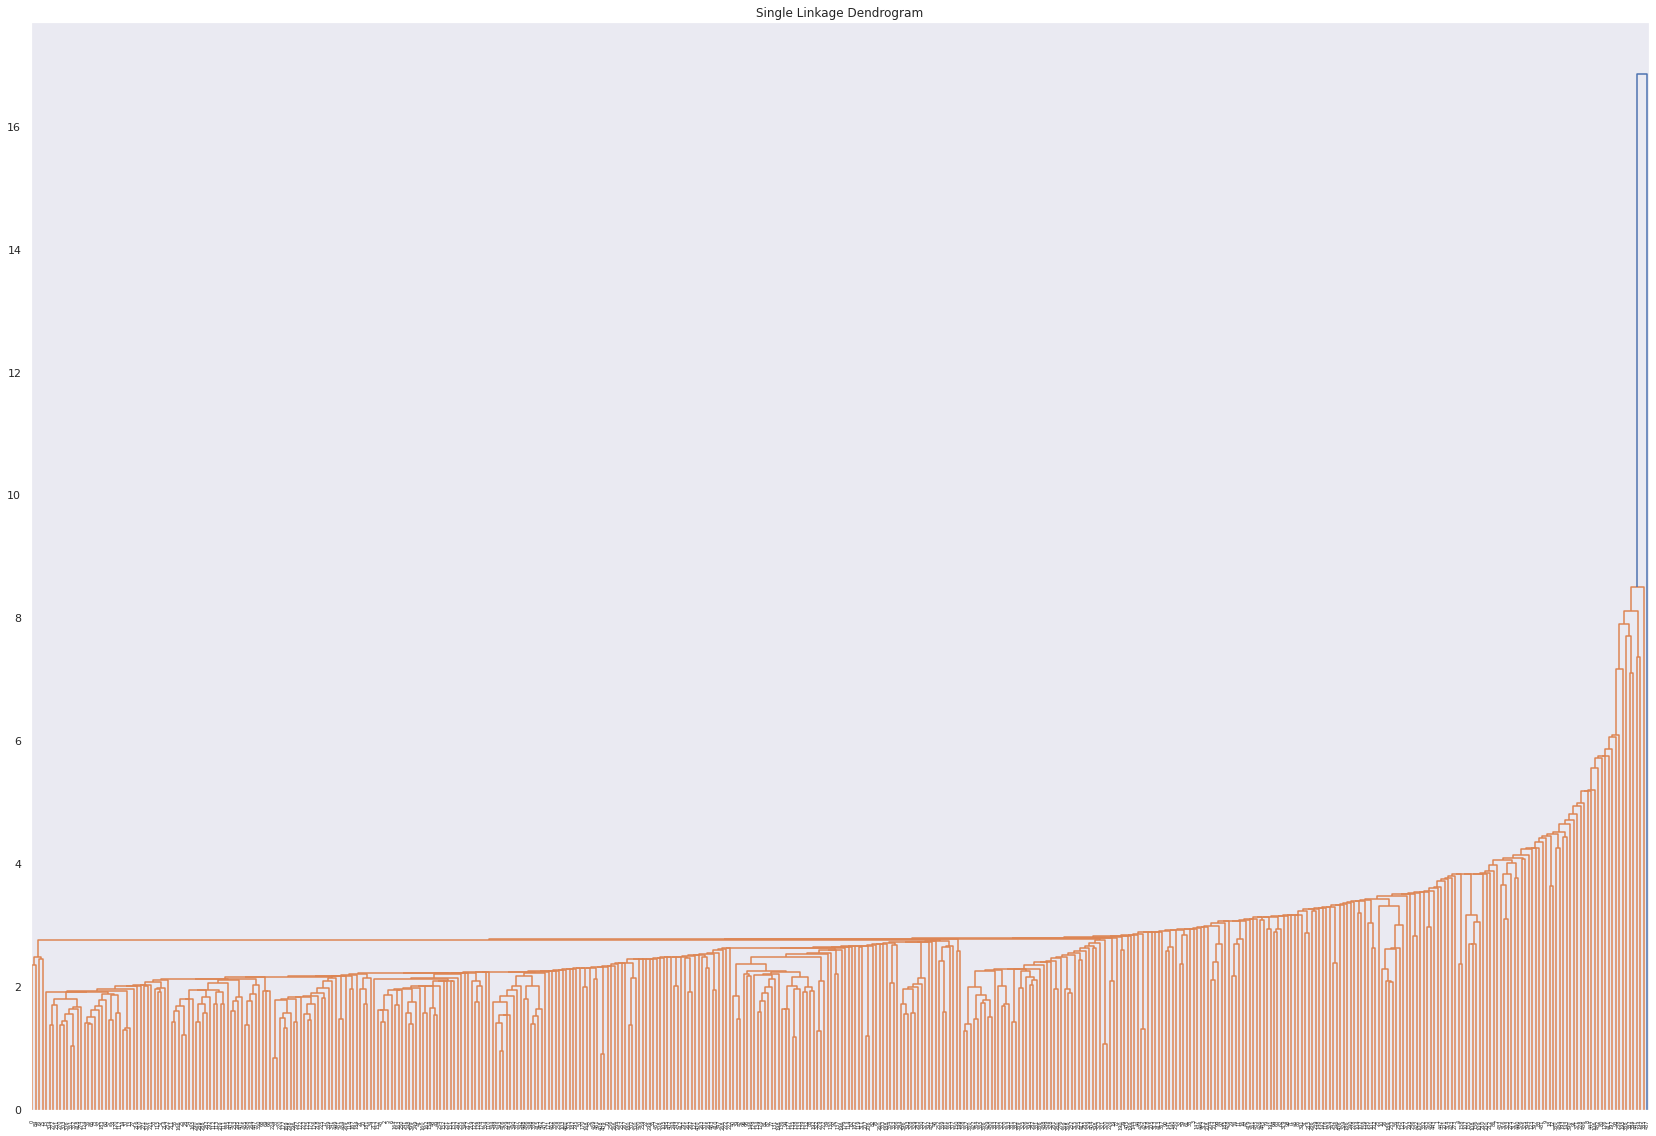

In [9]:
single = AgglomerativeClustering(linkage='single',compute_distances=True)
single = single.fit(npf_normalized)

plt.figure(figsize=(29, 20))
plt.grid(visible=None)
plt.title("Single Linkage Dendrogram")
plot_dendrogram(single)

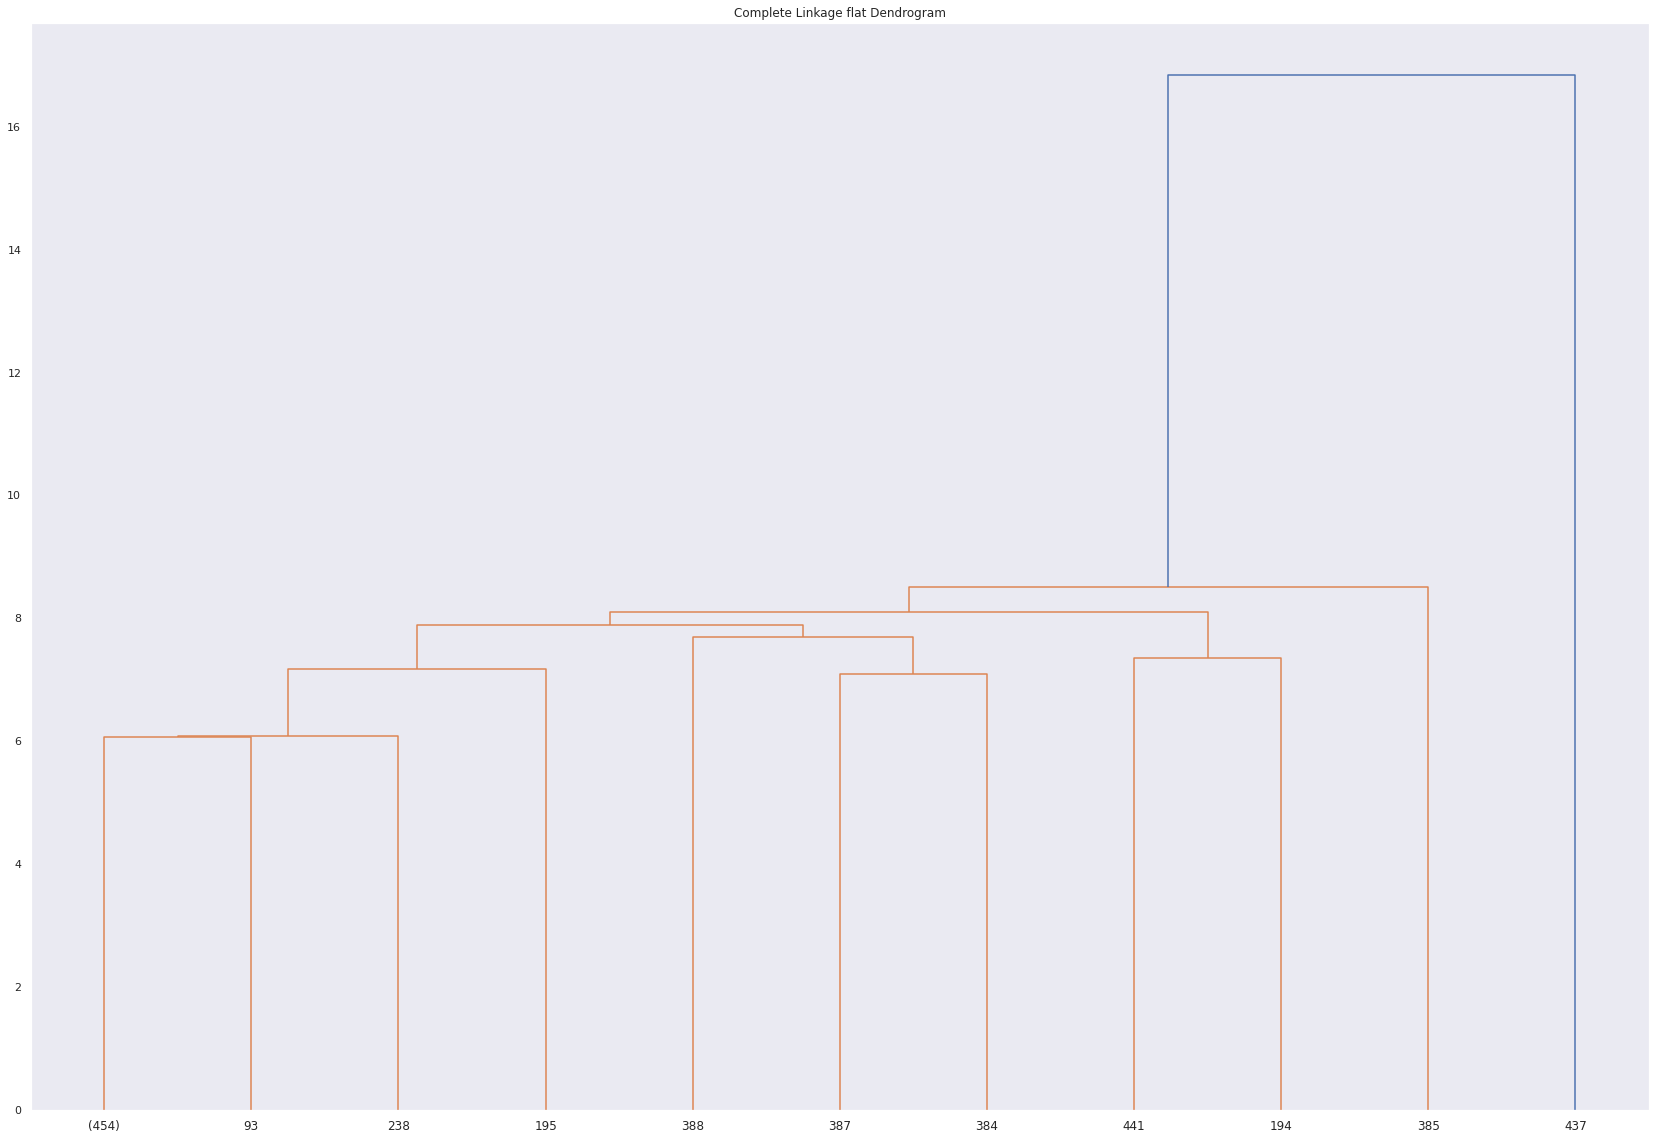

In [10]:
plt.figure(figsize=(29, 20))
plt.grid(visible=None)
plt.title("Complete Linkage flat Dendrogram")
plot_dendrogram(single, truncate_mode="level", p=6)

We can see that with single linkage we get a *very* sekwed dendrogram, where almost all the datapoints are clustered into the left, into the orange branch and setting a single point to the right. The complete linkage produces a bit of a more balanced separation, but we can still observe some skew toward the green classifications. However, this is still more evenly distributed than the single linkage, which we can observe with how "squeezed" the branches on each dendrogram are. With single linkage, we end up visualizing branches that are way more squeezed than with complete linkage, which gives us an idea about how the distribution relates to each linkage function.

We can also observe, from the flattened dendrograms, that for a given depth of 6, complete linkage has considerably more branches than single linkage, which confirms that the complete linkage produces a more evenly spread out dendrogram. The size of the cluster, given by the children of each branch, is also a bit more even.

## Problem 20

### Task a

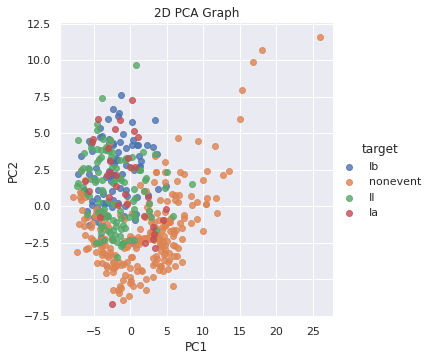

In [11]:
from sklearn.decomposition import PCA

X = npf_normalized
y = npf["class4"].values

pca = PCA(n_components=2)

# Fit and transform data
pca_features = pca.fit_transform(X)

# Create dataframe
pca_df = pd.DataFrame(
    data = pca_features,
    columns=['PC1', 'PC2'])

inv_pairs = {v: k for k, v in pairs.items()}

pca_df['target'] = y

sns.lmplot(
    x='PC1',
    y='PC2',
    data=pca_df,
    hue='target',
    fit_reg=False,
    legend=True
)

plt.title('2D PCA Graph')
plt.show()

### Task b

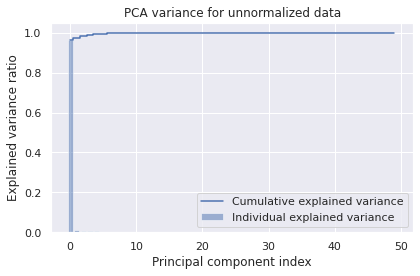

In [12]:
X = npf_unnormalized

pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("PCA variance for unnormalized data")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

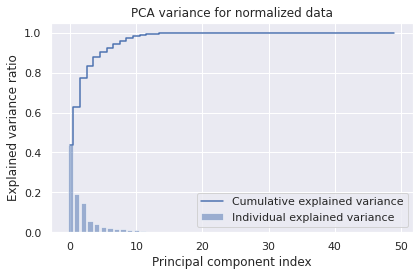

In [13]:
X = npf_normalized

pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("PCA variance for normalized data")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The dataset's covariates have inherently different scales. For example, the levels of CO2 are in the scale of hundreds, while the UV radiation is measured in the scale of hundredths or thousandths. This means that when analyzing the PCA, we may end up giving way more weight to the CO2, since it has a way bigger variance due to its scale.

### Task c

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

npf['class2'] = (npf['class4'] != 'nonevent').astype(int)

X_train, X_val, y_train, y_val = train_test_split(npf_normalized, npf["class2"], test_size=0.5, random_state=0)

# The default value of k is 5, so this is 5-nearest neighbors
clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(f'Binary accuracy without PCA: {accuracy_score(y_val,y_pred)}')

Binary accuracy without PCA: 0.8577586206896551


In [15]:
n = 17
pca = PCA(n_components = n)
X_pca = pca.fit_transform(npf_normalized)

X_train, X_val, y_train, y_val = train_test_split(X_pca, npf["class2"], test_size=0.5, random_state=0)

clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(f'Binary accuracy with PCA to {n} components: {accuracy_score(y_val,y_pred)}')

Binary accuracy with PCA to 17 components: 0.8663793103448276


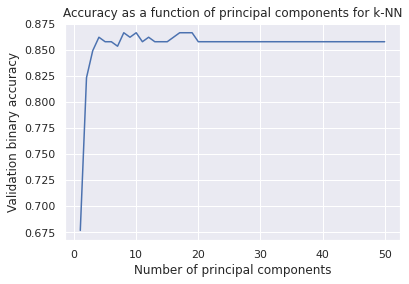

In [16]:
def plot_pca_effect(n = 50):
    comp_amount = np.arange(1, n+1)
    acc_log = np.zeros(n)
    
    for i in comp_amount:
        pca = PCA(n_components = i)
        X_pca = pca.fit_transform(npf_normalized)

        X_train, X_val, y_train, y_val = train_test_split(X_pca, npf["class2"], test_size=0.5, random_state=0)

        clf = KNeighborsClassifier()
        clf = clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)
        
        acc_log[i-1] = accuracy_score(y_val,y_pred)
    
    plt.plot(comp_amount, acc_log)
    plt.ylabel("Validation binary accuracy")
    plt.xlabel("Number of principal components")
    plt.title("Accuracy as a function of principal components for k-NN")
    plt.show()
    return

plot_pca_effect()

We can see some peaks and troughs in the plot of the binary accuracy as a function of the amount of principal components used. This indicates that there *is* some dimension for which we can get an optimal amount of information for our training algorithm. We can see some performance improvements for some values between 10 and 20 components, after which we just get the same accuracy. This tells us that the most informative covariates on the dataset are within the first 10 to 20 principal components, and the subsequent terms don't really contribute much information. However we must keep in mind that keeping too little components ends up not giving information at all for learning, which can be seen with the cliff on the left of the plot.

## Problem 21

With these topics we have learned about the basics of unsupervised learning, in particular for studying the structure of data and how we can make use of this to improve our understanding how phenomena are associated with our observed values. These are very valuable tools for our studies and work as data scientist, since understanding and explaining the data is usually considered the bulk of our work right after data cleaning. Understanding k-means allows us to see patterns in the data we study, hierarchical clustering gives us insights into how different datapoints are related and PCA is a really valuable tool in reducing the dimensionality we must work with and helps us understand what environmental characteristics have the most effect on the observations of a certain phenomenon we observe.